<a href="https://www.kaggle.com/code/isaiasceciliano/hotel-cancellations-prediction-ml-dl?scriptVersionId=125602075" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## 0. Librerías

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import metrics
import xgboost as xgb
from skopt import BayesSearchCV
from yellowbrick.classifier.rocauc import roc_auc

import cufflinks as cf
from IPython.display import display,HTML
show_html = lambda html : display(HTML(html))


from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

cf.set_config_file(sharing='public',theme='polar',offline=True)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



## 1.Data Pre-Processing

### 1.1 Exploración de los datos

In [2]:
df_reserv = pd.read_csv('/kaggle/input/hotel-reservations-classification-dataset/Hotel Reservations.csv')
print(df_reserv.columns)
df_reserv
# Variable dependiente : booking_status
# Variables independientes: todas las demás

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


In [3]:
cls = [str(v) for v in sorted(df_reserv['booking_status'].unique())]
cls

['Canceled', 'Not_Canceled']

### 1.2 Formato

#### Codificamos y reescribimos las columnas con variables categóricas.
Creamos dos columnas nuevas, las cuales contienen el total de personas, y el total de noches.

In [4]:
le = preprocessing.LabelEncoder()

categorical_features = ['booking_status','room_type_reserved','type_of_meal_plan','market_segment_type','required_car_parking_space']

for column in categorical_features:
    df_reserv[column] = le.fit_transform(df_reserv[column])

# Ejemplo de un solo elemento si no se usa el bucle for:
#df_reserv['booking_status'] = le.fit_transform(df_reserv['booking_status'])


df_reserv['total_person'] = df_reserv['no_of_children'] + df_reserv['no_of_adults']
df_reserv['total_nights'] = df_reserv['no_of_weekend_nights'] + df_reserv['no_of_week_nights']
df_reserv

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,total_person,total_nights
0,INN00001,2,0,1,2,0,0,0,224,2017,...,2,3,0,0,0,65.00,0,1,2,3
1,INN00002,2,0,2,3,3,0,0,5,2018,...,6,4,0,0,0,106.68,1,1,2,5
2,INN00003,1,0,2,1,0,0,0,1,2018,...,28,4,0,0,0,60.00,0,0,1,3
3,INN00004,2,0,0,2,0,0,0,211,2018,...,20,4,0,0,0,100.00,0,0,2,2
4,INN00005,2,0,1,1,3,0,0,48,2018,...,11,4,0,0,0,94.50,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,0,0,3,85,2018,...,3,4,0,0,0,167.80,1,1,3,8
36271,INN36272,2,0,1,3,0,0,0,228,2018,...,17,4,0,0,0,90.95,2,0,2,4
36272,INN36273,2,0,2,6,0,0,0,148,2018,...,1,4,0,0,0,98.39,2,1,2,8
36273,INN36274,2,0,0,3,3,0,0,63,2018,...,21,4,0,0,0,94.50,0,0,2,3


### 1.3 Análisis estadístico y correlación

#### Matriz de correlación

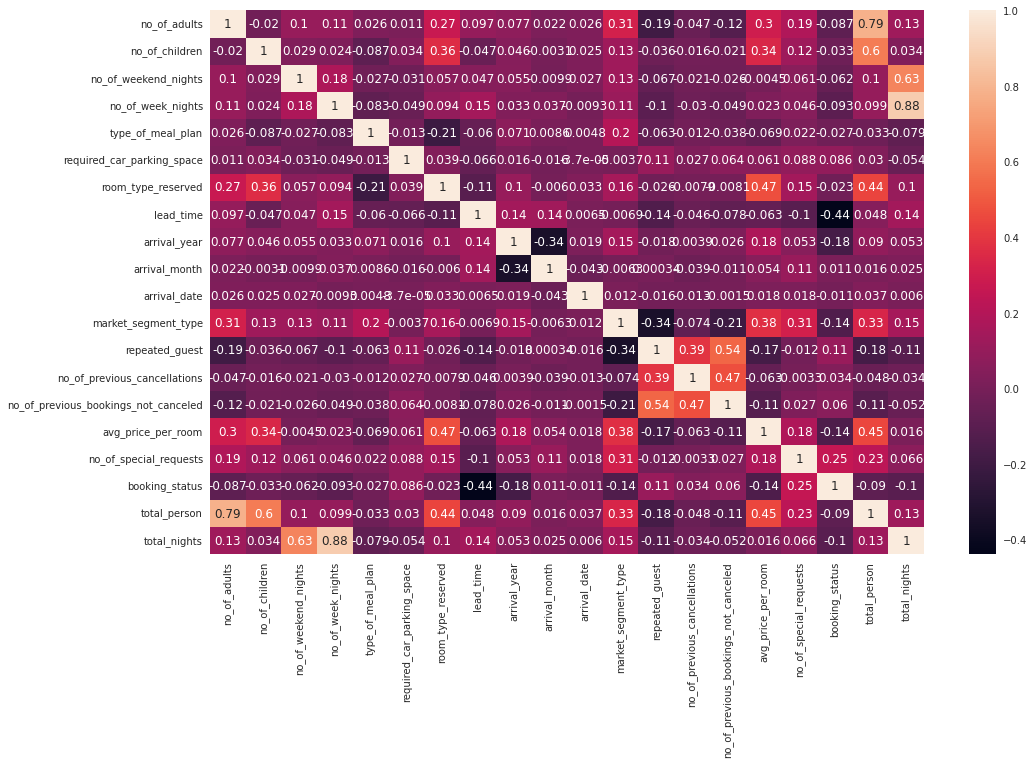

In [5]:
corr_mat= df_reserv.corr(method='pearson')  
plt.figure(figsize=(16,10))
dataplot = sb.heatmap(corr_mat,annot=True)  
plt.show()

## 2 Filtrado, definición de variables, creación de training set y testing set, feature scaling

In [6]:
# Eliminamos las columnas que no son de nuestro interés
X_list = ['repeated_guest','type_of_meal_plan',
       'room_type_reserved', 'lead_time', 'market_segment_type',
       'avg_price_per_room', 'no_of_special_requests','required_car_parking_space']
total_columns = ['repeated_guest','type_of_meal_plan',
       'room_type_reserved', 'lead_time', 'market_segment_type',
       'avg_price_per_room', 'no_of_special_requests','required_car_parking_space','booking_status']
df_filt= df_reserv[total_columns]

# Definimos las variables independientes y la variable dependiente
X = df_filt.iloc[:,0:-1].values
y = df_filt.loc[:, 'booking_status'].values

# Separamos los datos en dos: training data y testing data
# random state : "semilla", es útil para que el'pipeline' sea determinista
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 43)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.15, random_state = 43)
# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
df_filt

,repeated_guest,type_of_meal_plan,room_type_reserved,lead_time,market_segment_type,avg_price_per_room,no_of_special_requests,required_car_parking_space,booking_status
0,0,0,0,224,3,65.00,0,0,1
1,0,3,0,5,4,106.68,1,0,1
2,0,0,0,1,4,60.00,0,0,0
3,0,0,0,211,4,100.00,0,0,0
4,0,3,0,48,4,94.50,0,0,0
...,...,...,...,...,...,...,...,...,...
36270,0,0,3,85,4,167.80,1,0,1
36271,0,0,0,228,4,90.95,2,0,0
36272,0,0,0,148,4,98.39,2,0,1
36273,0,3,0,63,4,94.50,0,0,0


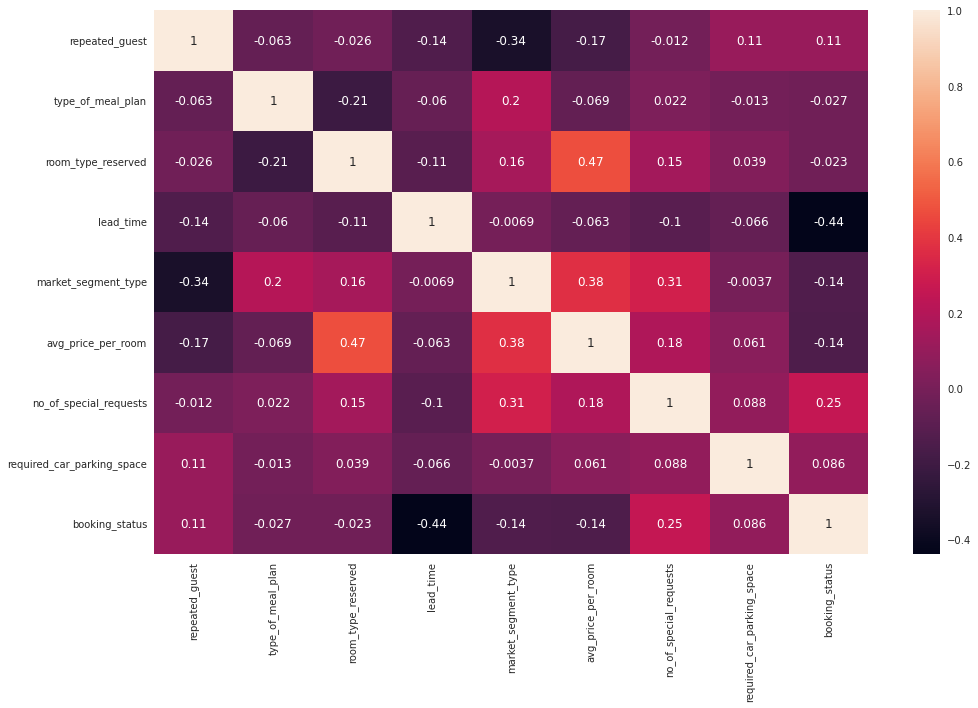

In [7]:
corr_mat= df_filt.corr(method='pearson')  
plt.figure(figsize=(16,10))
dataplot = sb.heatmap(corr_mat,annot=True,)  
plt.show()
#mask = np.triu(np.ones_like(corr_mat, dtype=bool))
#sb.heatmap(corr_mat,cmap='seismic',linewidth=6,linecolor='white',vmax = 1, vmin=-1,mask=mask, annot=True,fmt='0.2f')
#plt.title('Correlation Heatmap', weight='bold',fontsize=15)
#plt.savefig('heatmap.png',transparent=True, bbox_inches='tight')

## 3 Modelos de Regresión y clasificación


### 3.1 Regresión Logística

#### penalty : {‘l1’, ‘l2’, ‘elasticnet’, None}, default=’l2’

* None: no penalty is added;

* 'l2': add a L2 penalty term and it is the default choice;

* 'l1': add a L1 penalty term;

* 'elasticnet': both L1 and L2 penalty terms are added

#### dual: bool, default=False

* Dual or primal formulation. Dual formulation is only implemented for l2 penalty with liblinear solver.Prefer dual=False when n_samples > n_features.

#### tol: float, default=1e-4

* Tolerance for stopping criteria.

#### C: float, default=1.0

* Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

#### fit_intercept: bool, default=True

* Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.

#### intercept_scaling: float, default=1

* Useful only when the solver ‘liblinear’ is used and self.fit_intercept is set to True. In this case, x becomes [x, self.intercept_scaling], i.e. a “synthetic” feature with constant value equal to intercept_scaling is appended to the instance vector. The intercept becomes intercept_scaling * synthetic_feature_weight.

** Note! the synthetic feature weight is subject to l1/l2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) intercept_scaling has to be increased.

#### class_weight: dict or ‘balanced’, default=None

* Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.

* The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

** Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.

** New in version 0.17: class_weight=’balanced’

#### random_stateint, RandomState instance, default=None

* Used when solver == ‘sag’, ‘saga’ or ‘liblinear’ to shuffle the data.

### solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’

Algorithm to use in the optimization problem. Default is ‘lbfgs’. To choose a solver, you might want to consider the following aspects:

* For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;

* For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;

* ‘liblinear’ is limited to one-versus-rest schemes.

* ‘newton-cholesky’ is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories. Note that it is limited to binary classification and the one-versus-rest reduction for multiclass classification. Be aware that the memory usage of this solver has a quadratic dependency on n_features because it explicitly computes the Hessian matrix.

In [8]:

cl_lr = LogisticRegression()
cl_lr.name = 'Logistic Regression'



## To do

* Un diccionario para cada modelo con el nombre de los parámetros a ajustar como keys, y en los values los posibles valores almacenados como listas.

* Encontrar la mejor configuración:
    
    cl_lr_opt = BayesSearchCV(cl_lr,cl_lr.param_adjust,n_iter=15,cv=5,n_jobs=-1,refit=True,random_state=0)

In [9]:
param_default = cl_lr.get_params()

param_keys = param_default.keys()
param_list = [str(v) for v in sorted(param_keys)]

param_default

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [10]:
#cl_lr.param_adjust = {'C': list(range(1,5),'class_weight': ['dict',None],'dual': [True,False],'fit_intercept': [True,False],'max_iter':'penalty': [‘l1’, ‘l2’, ‘elasticnet’, None]}
cl_lr.param_adjust = {'C': list(range(1,5))}          
cl_lr_opt = BayesSearchCV(cl_lr,cl_lr.param_adjust,n_iter=15,cv=5,n_jobs=-1,refit=True,random_state=0)

cl_lr_opt.fit(X_train,y_train)

show_html(pd.DataFrame(cl_lr_opt.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].
          sort_values(by='rank_test_score').head().to_html())

/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



,params,mean_test_score,rank_test_score
0,{'C': 3},0.798787,1
1,{'C': 2},0.798787,1
2,{'C': 3},0.798787,1
3,{'C': 1},0.798787,1
4,{'C': 2},0.798787,1


### 3.2 Support Vector Machines (Ajustar parámetros)

In [11]:
cl_svm_pol = SVC(kernel ='poly', degree = 4)
cl_svm_pol.name = 'SVM - poly kernel'

cl_svm_rbf  = SVC(kernel ='rbf', random_state = 0)
cl_svm_rbf.name = 'SVM - RBF kernel'

cl_svm_sig = SVC(kernel ='sigmoid')
cl_svm_sig.name = 'SVM - Sigmoid kernel '

cl_svm_lin = SVC(kernel ='linear')
cl_svm_lin.name = 'SVM - linear kernel'

#print(classification_report(y_test,y_pred))


### 3.3 Decision Tree

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

For instance, in the example below, decision trees learn from data to approximate a sine curve with a set of if-then-else decision rules. The deeper the tree, the more complex the decision rules and the fitter the model.

#### Desventajas

Decision-tree learners can create over-complex trees that do not generalize the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.

Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.

Predictions of decision trees are neither smooth nor continuous, but piecewise constant approximations as seen in the above figure. Therefore, they are not good at extrapolation.

The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.

There are concepts that are hard to learn because decision trees do not express them easily, such as XOR, parity or multiplexer problems.

Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

In [12]:
cl_dt = DecisionTreeClassifier()#(criterion = 'entropy', random_state = 43)
cl_dt.name = 'Desicion Tree'

### 3.4 XGB Booster

XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman.

The gradient boosted trees has been around for a while, and there are a lot of materials on the topic. This tutorial will explain boosted trees in a self-contained and principled way using the elements of supervised learning. We think this explanation is cleaner, more formal, and motivates the model formulation used in XGBoost.

In [13]:
cl_xgb = xgb.XGBClassifier()
cl_xgb.name = 'Extreme Gradient Boosting (XGB)'

### 3.5 Random Forest

class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)[source]¶

In [14]:
acc_rf = []
valores_k = []

In [15]:
for k in range(10,30):

    cl_rf = RandomForestClassifier(n_estimators=k, random_state=6)
    cl_rf.fit(X_train, y_train)
    y_pred = cl_rf.predict(X_test)    
    x = metrics.accuracy_score(y_test, y_pred)
    acc_rf.append(x)
    valores_k.append(k)

data_rf = np.array([acc_rf])
df_rf = pd.DataFrame(data_rf.T.round(5)*100, index = valores_k,
            columns= ['Accuracy (%)']).sort_values('Accuracy (%)', ascending=[False])
df_rf.index.name = "n_estimators"

k_max = df_rf['Accuracy (%)'].index[0]
k = k_max

cl_rf_opt = RandomForestClassifier(n_estimators=k_max, random_state=6)
cl_rf_opt.name = 'Random Forest' + " " + 'n_estimators:'+ " " + str(k_max)
df_rf

,Accuracy (%)
n_estimators,
17,87.229
25,87.174
21,87.137
23,87.119
22,87.100
27,87.082
13,87.082
14,87.082
15,87.082


### 3.6 Gaussian Naive Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. Bayes’ theorem states the following relationship, given class variable and dependent feature vector X1 through Xn 

In [16]:
cl_gnb =  GaussianNB()
cl_gnb.name = 'Gaussian Naive Bayes'


### 3.7 K-Nearest Neighbors

In [17]:
valores_j = []
acc_kn = []

In [18]:

for j in range(10,100):
    cl_kn = KNeighborsClassifier(n_neighbors=j)          
    ##algo pasa acá
    
    cl_kn.fit(X_train, y_train)
    y_pred = cl_kn.predict(X_test)    
    
    x = metrics.accuracy_score(y_test, y_pred)
    acc_kn.append(x)
    valores_j.append(j)

data_kn = np.array([acc_kn])
df_kn = pd.DataFrame(data_kn.T.round(5)*100, index = valores_j,
            columns= ['Accuracy (%)']).sort_values('Accuracy (%)', ascending=[False])
df_kn.index.name = "n_neighbors"

j_max = df_kn['Accuracy (%)'].index[0]
j = j_max

cl_kn_opt = KNeighborsClassifier(n_neighbors=j_max)    
cl_kn_opt.name = 'K-Nearest Neighbors' + ' ' + 'n_neighbors = ' + str(j_max)
df_kn

,Accuracy (%)
n_neighbors,
19,86.182
20,86.090
17,86.071
21,86.053
11,86.016
...,...
85,83.664
91,83.646
96,83.646


### 3.8 Multilayer Perceptron Neural Network

In [19]:
param = {'hidden_layer_sizes':[10,50,100,200,300],'activation':['relu','identity','logistic'],
         'alpha':[0.0001,0.001,0.01],'momentum':[0.95,0.90,0.85,0.80],
         'learning_rate_init':[0.001,0.01,0.1],'n_iter_no_change':[10,20,30,40,50],
         'learning_rate':['constant','invscaling','adaptive']}
# 'Momentum'for gradient descent update. Should be between 0 and 1
# 'constant' is a constant learning rate given by 'learning_rate_int'.
# 'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent
# 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing
# or fall to increase validation socre by at least the tolerance the
# current learning rate is divided by

mlp = MLPClassifier(max_iter=10000,early_stopping=True,random_state=0)
mlp_bs = BayesSearchCV(mlp,param,n_iter=15,cv=5,n_jobs=-1,refit=True,random_state=0)
mlp_bs.name = 'Multilayer Perceptron Neural Network'
mlp_bs.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=MLPClassifier(early_stopping=True, max_iter=10000,
                                      random_state=0),
              n_iter=15, n_jobs=-1, random_state=0,
              search_spaces={'activation': ['relu', 'identity', 'logistic'],
                             'alpha': [0.0001, 0.001, 0.01],
                             'hidden_layer_sizes': [10, 50, 100, 200, 300],
                             'learning_rate': ['constant', 'invscaling',
                                               'adaptive'],
                             'learning_rate_init': [0.001, 0.01, 0.1],
                             'momentum': [0.95, 0.9, 0.85, 0.8],
                             'n_iter_no_change': [10, 20, 30, 40, 50]})

In [20]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].
          sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
11,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 50, 'learning_rate': 'invscaling', 'learning_rate_init': 0.1, 'momentum': 0.9, 'n_iter_no_change': 30}",0.835468,1
14,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'momentum': 0.85, 'n_iter_no_change': 50}",0.834690,2
5,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'momentum': 0.85, 'n_iter_no_change': 40}",0.833458,3
0,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'momentum': 0.95, 'n_iter_no_change': 20}",0.833068,4
12,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'momentum': 0.9, 'n_iter_no_change': 50}",0.831804,5


In [21]:
print(classification_report(mlp_bs.predict(X_test),y_test,target_names=cls))

              precision    recall  f1-score   support

    Canceled       0.72      0.79      0.75      1624
Not_Canceled       0.91      0.87      0.89      3818

    accuracy                           0.85      5442
   macro avg       0.81      0.83      0.82      5442
weighted avg       0.85      0.85      0.85      5442



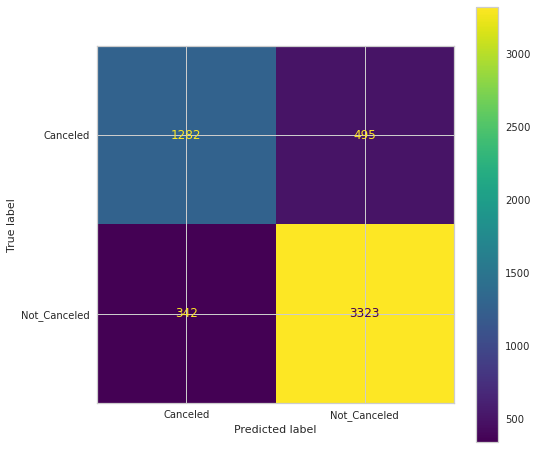

In [22]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(mlp_bs,X_test,y_test,display_labels=cls,ax=plt.subplot())

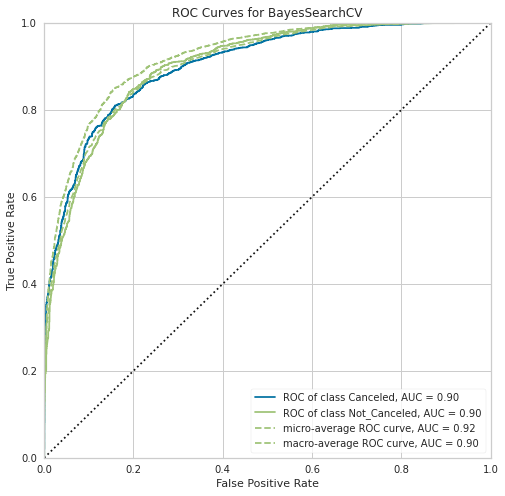

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for BayesSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=['Canceled', 'Not_Canceled'],
       estimator=BayesSearchCV(cv=5,
                               estimator=MLPClassifier(early_stopping=True,
                                                       max_iter=10000,
                                                       random_state=0),
                               n_iter=15, n_jobs=-1, random_state=0,
                               search_spaces={'activation': ['relu', 'identity',
                                                             'logistic'],
                                              'alpha': [0.0001, 0.001, 0.01],
                                              'hidden_layer_sizes': [10, 50,
                                                                     100, 200,
                                                                     300],
                                  

In [23]:
plt.figure(figsize=(8,8))
roc_auc(mlp_bs,X_train,y_train,X_test,y_test,classes=cls)

## 4 Fitting de los distintos modelos y Visualización de resultados

In [24]:
acc = []
model = []
Classifiers_list = [cl_lr, cl_rf_opt, cl_kn_opt, cl_dt, cl_xgb, cl_gnb,cl_svm_pol,cl_svm_rbf,cl_svm_sig,cl_svm_lin,mlp_bs]



,params,mean_test_score,rank_test_score
11,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 50, 'learning_rate': 'invscaling', 'learning_rate_init': 0.1, 'momentum': 0.9, 'n_iter_no_change': 30}",0.835468,1
14,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'momentum': 0.85, 'n_iter_no_change': 50}",0.834690,2
5,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'momentum': 0.85, 'n_iter_no_change': 40}",0.833458,3
0,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'momentum': 0.95, 'n_iter_no_change': 20}",0.833068,4
12,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'momentum': 0.9, 'n_iter_no_change': 50}",0.831804,5


              precision    recall  f1-score   support

    Canceled       0.72      0.79      0.75      1624
Not_Canceled       0.91      0.87      0.89      3818

    accuracy                           0.85      5442
   macro avg       0.81      0.83      0.82      5442
weighted avg       0.85      0.85      0.85      5442



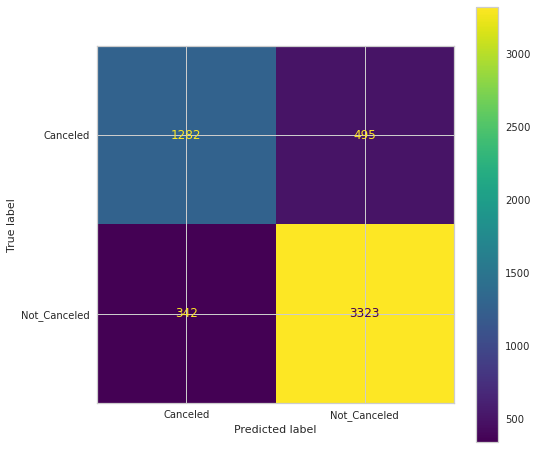

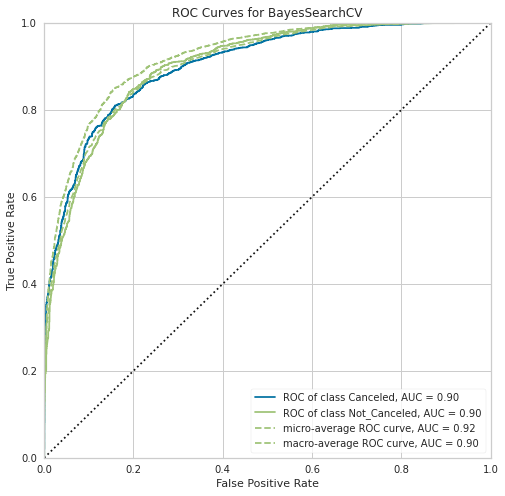

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for BayesSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=['Canceled', 'Not_Canceled'],
       estimator=BayesSearchCV(cv=5,
                               estimator=MLPClassifier(early_stopping=True,
                                                       max_iter=10000,
                                                       random_state=0),
                               n_iter=15, n_jobs=-1, random_state=0,
                               search_spaces={'activation': ['relu', 'identity',
                                                             'logistic'],
                                              'alpha': [0.0001, 0.001, 0.01],
                                              'hidden_layer_sizes': [10, 50,
                                                                     100, 200,
                                                                     300],
                                  

In [25]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].
          sort_values(by='rank_test_score').head().to_html())
print(classification_report(mlp_bs.predict(X_test),y_test,target_names=cls))

plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(mlp_bs,X_test,y_test,display_labels=cls,ax=plt.subplot())

plt.figure(figsize=(8,8))
roc_auc(mlp_bs,X_train,y_train,X_test,y_test,classes=cls)

### El siguiente algoritmo pretende automatizar la visualización de los resultados, tomando como base la implementación usada en Multilayer Neura Network


### Automatización del algoritmo para implementar cada clasificador

#### La función apply_classifier realiza varias tareas:

* Fitting del clasificador
* Estimación y almacenamiento en la lista "acc" , del accuracy score
* Almacenamiento del nombre del atributo "name" en la lista "model". 
* Visualización de la matriz de confusión, con valores netos y otra versión normalizada, esta última es útil para visualizar mejor los errores tipo I y tipo II.
*Fuera de la función se crea un ciclo for para aplicar la función a todos los elementos en "Classifiers_list"

Logistic Regression Accuracy is:  0.799


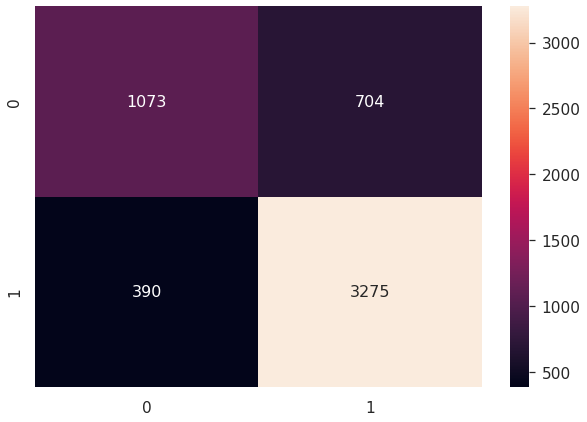

Logistic Regression Model Confusion Matrix, normalized


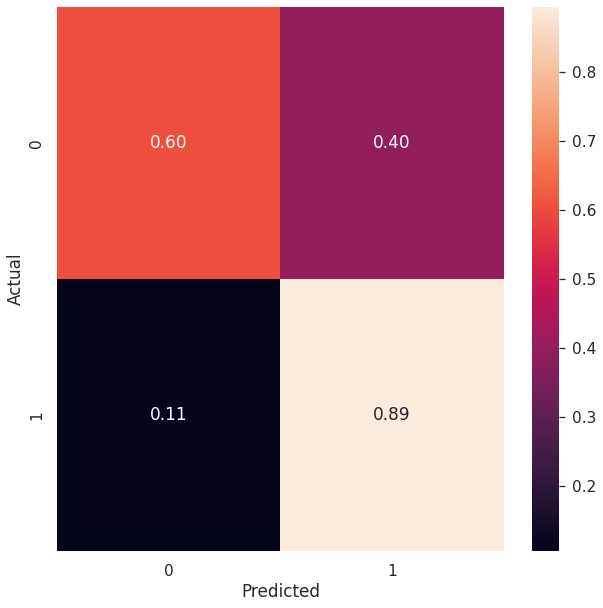

Random Forest n_estimators: 17 Accuracy is:  0.8723


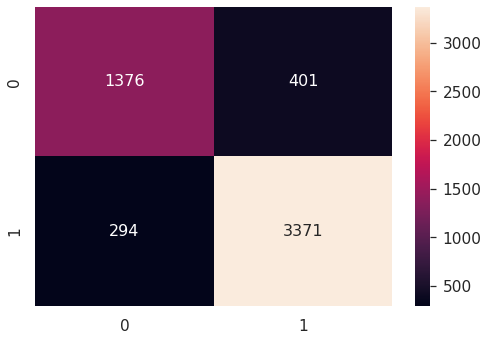

Random Forest n_estimators: 17 Model Confusion Matrix, normalized


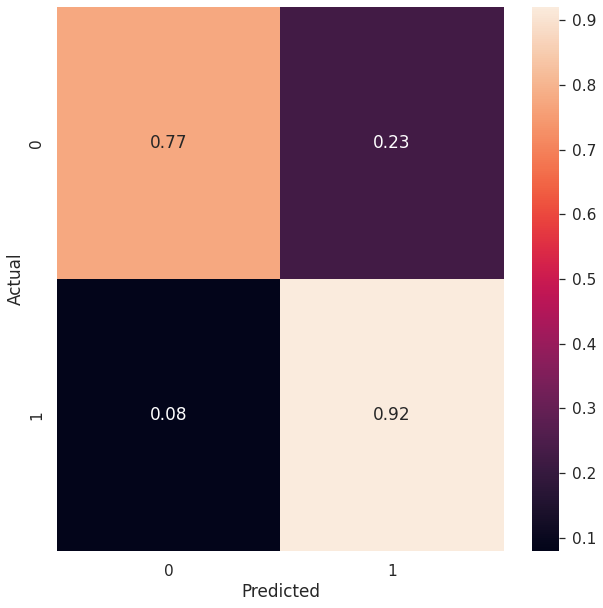

K-Nearest Neighbors n_neighbors = 19 Accuracy is:  0.8618


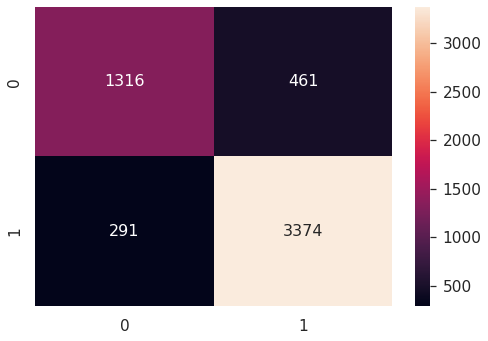

K-Nearest Neighbors n_neighbors = 19 Model Confusion Matrix, normalized


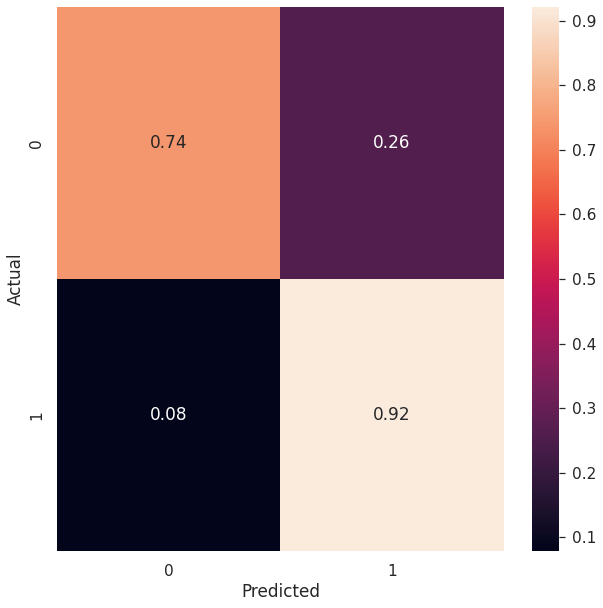

Desicion Tree Accuracy is:  0.8515


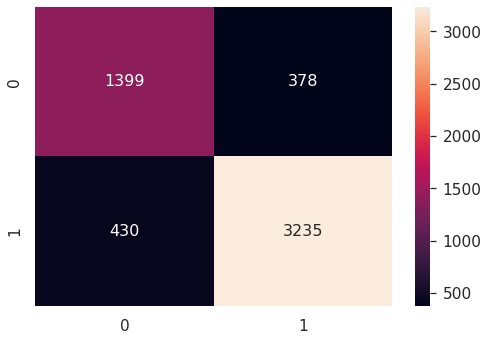

Desicion Tree Model Confusion Matrix, normalized


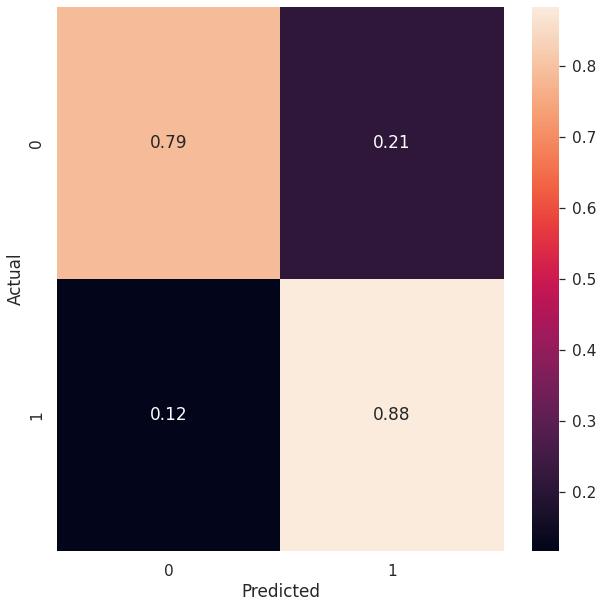

Extreme Gradient Boosting (XGB) Accuracy is:  0.8771


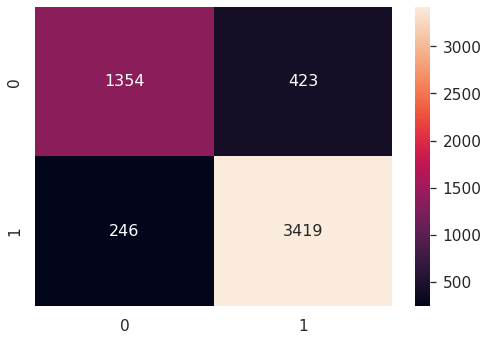

Extreme Gradient Boosting (XGB) Model Confusion Matrix, normalized


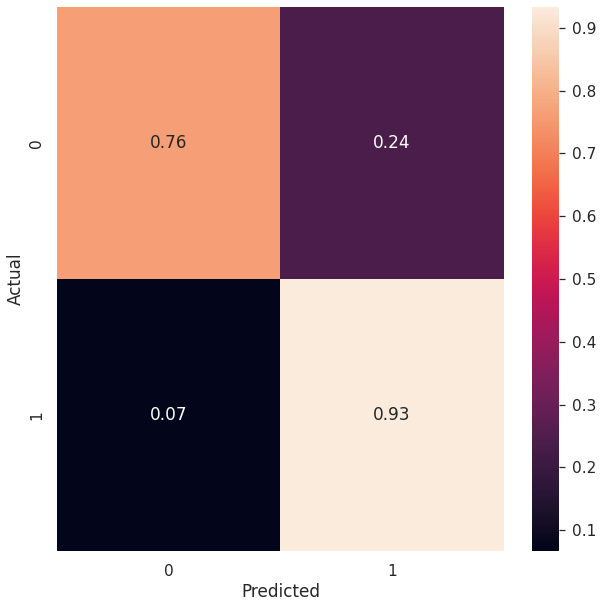

Gaussian Naive Bayes Accuracy is:  0.5266


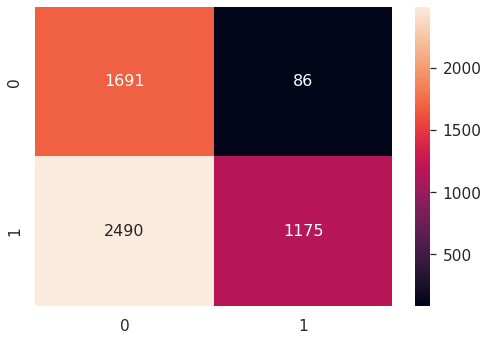

Gaussian Naive Bayes Model Confusion Matrix, normalized


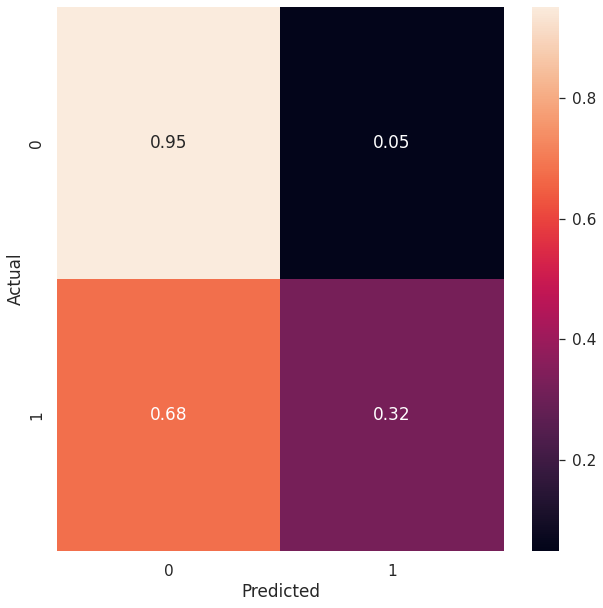

SVM - poly kernel Accuracy is:  0.7981


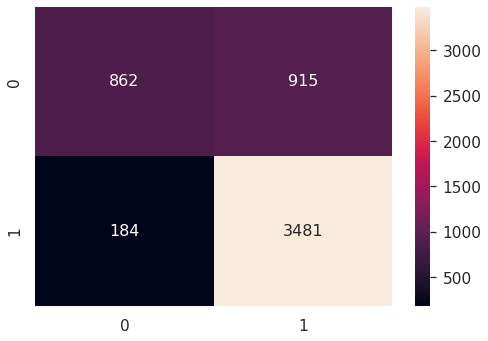

SVM - poly kernel Model Confusion Matrix, normalized


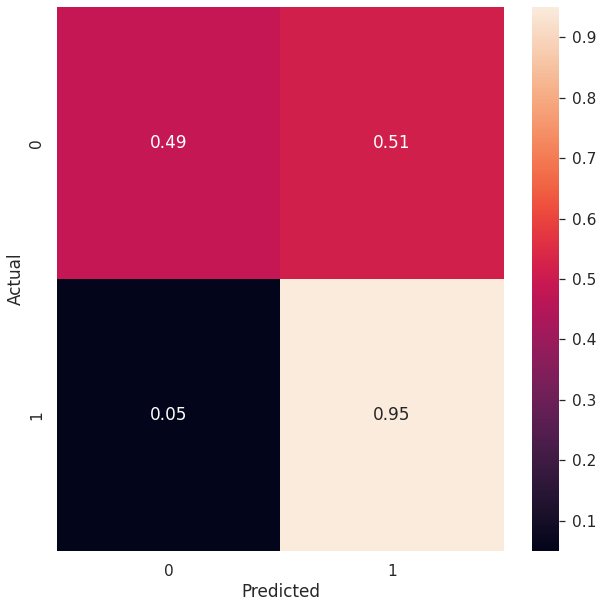

SVM - RBF kernel Accuracy is:  0.8298


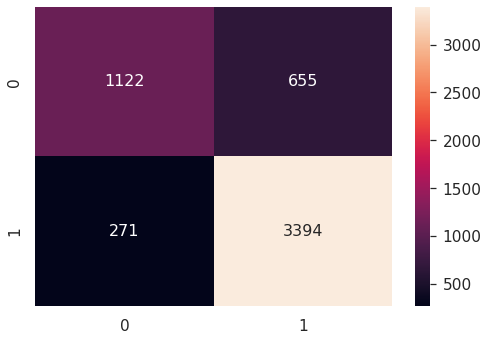

SVM - RBF kernel Model Confusion Matrix, normalized


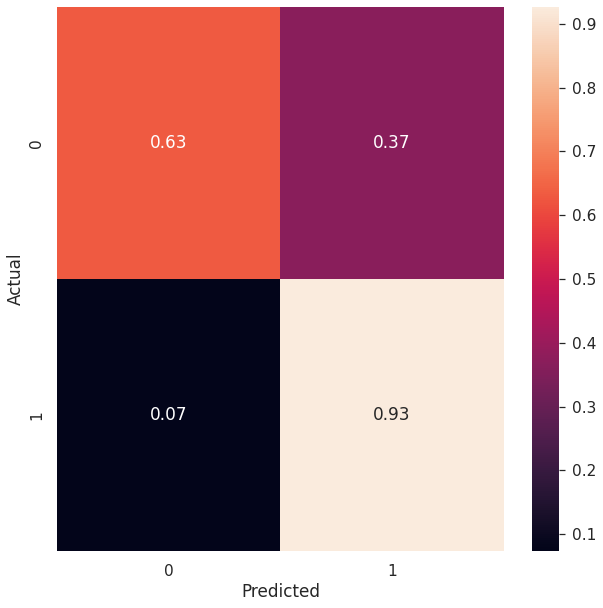

SVM - Sigmoid kernel  Accuracy is:  0.7019


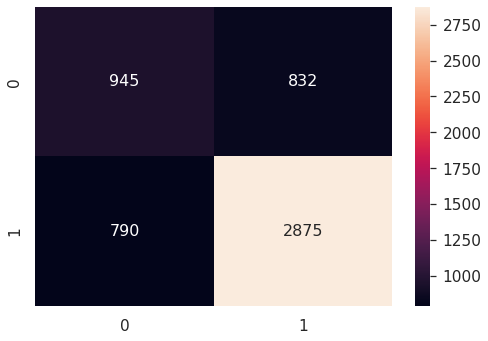

SVM - Sigmoid kernel  Model Confusion Matrix, normalized


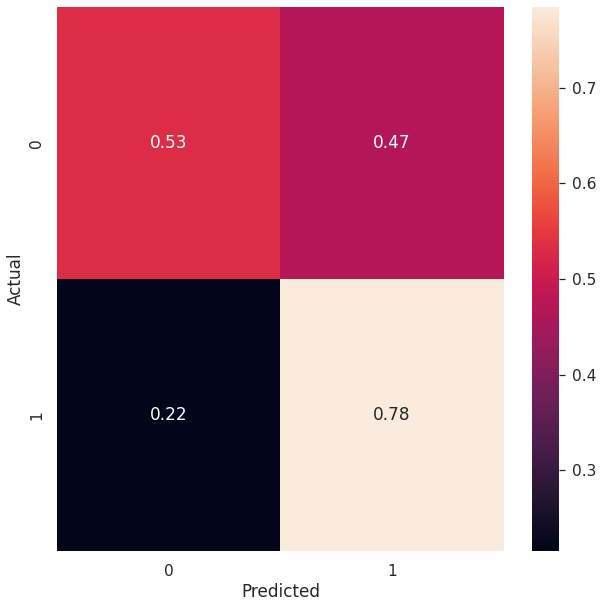

SVM - linear kernel Accuracy is:  0.7973


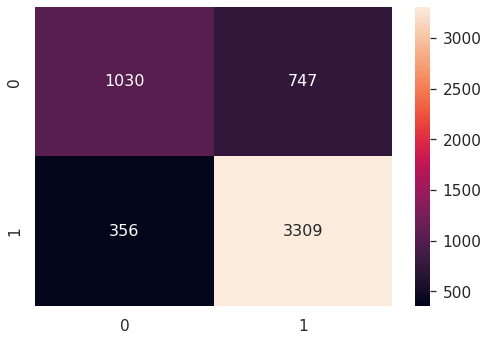

SVM - linear kernel Model Confusion Matrix, normalized


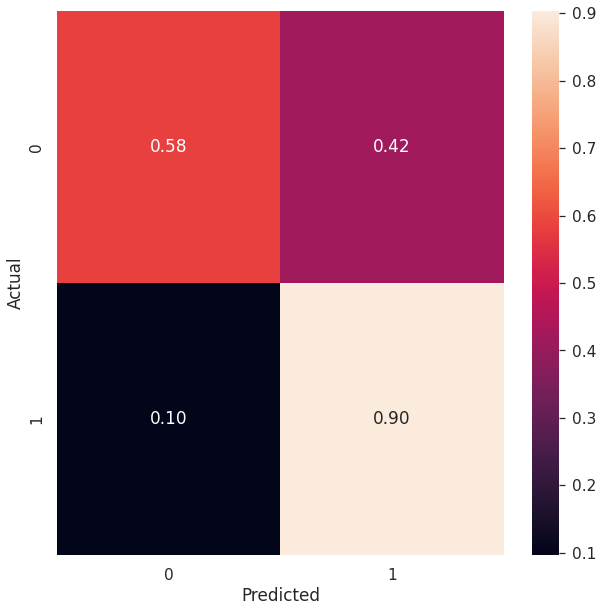

Multilayer Perceptron Neural Network Accuracy is:  0.8462


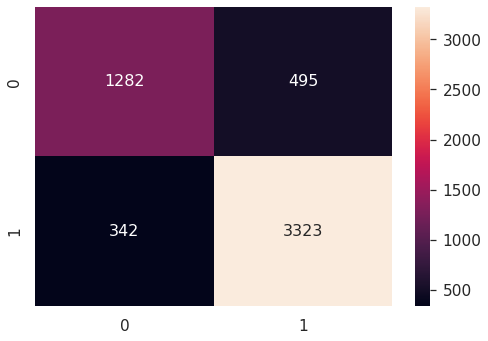

Multilayer Perceptron Neural Network Model Confusion Matrix, normalized


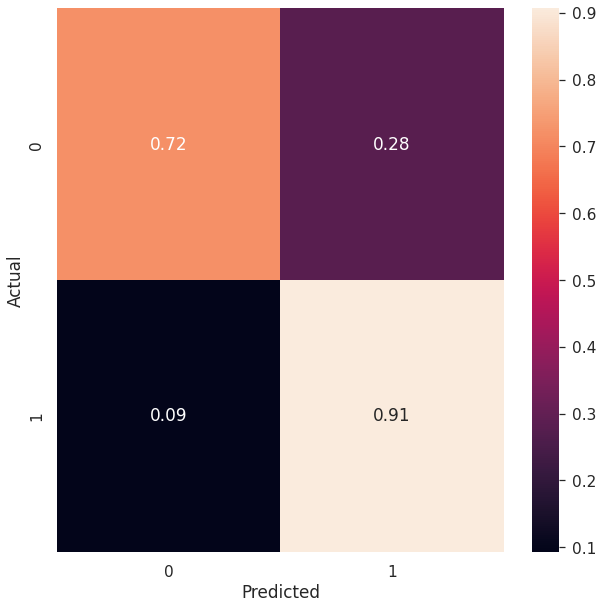

In [26]:
plt.figure(figsize=(10,7))
sb.set(font_scale=1.4) # for label size

def apply_classifier(cl):
    cl.fit(X_train, y_train)
    y_pred = cl.predict(X_test)
    #cm = confusion_matrix(y_test, y_pred)    tal vez no es necesario

    x = metrics.accuracy_score(y_test, y_pred)
    acc.append(x)
    model.append(cl.name)
    
    print(str(cl.name) + " " + "Accuracy is: ", x.round(4))
    cm = confusion_matrix(y_test,y_pred)
    sb.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='d') # font size
    plt.show()
    
    print(str(cl.name) + " " + "Model Confusion Matrix, normalized")
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sb.heatmap(cmn, annot=True, fmt='.2f')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
   
for modelo in Classifiers_list:
    apply_classifier(modelo)

### Creamos un nuevo DataFrame con el accuracy como columna y el nombre del modelo como índice, ordenamos los valores de forma descendente

In [27]:
data = np.array([acc])

df = pd.DataFrame(data.T.round(5)*100, index = model,
            columns= ['Accuracy (%)']).sort_values('Accuracy (%)', ascending=[False])
df

,Accuracy (%)
Extreme Gradient Boosting (XGB),87.707
Random Forest n_estimators: 17,87.229
K-Nearest Neighbors n_neighbors = 19,86.182
Desicion Tree,85.153
Multilayer Perceptron Neural Network,84.620
SVM - RBF kernel,82.984
Logistic Regression,79.897
SVM - poly kernel,79.805
SVM - linear kernel,79.732
SVM - Sigmoid kernel,70.195


### Algunos plots que ayudan a visualizar la exactitud según el modelo

<AxesSubplot:xlabel='Accuracy', ylabel='Algorithm'>

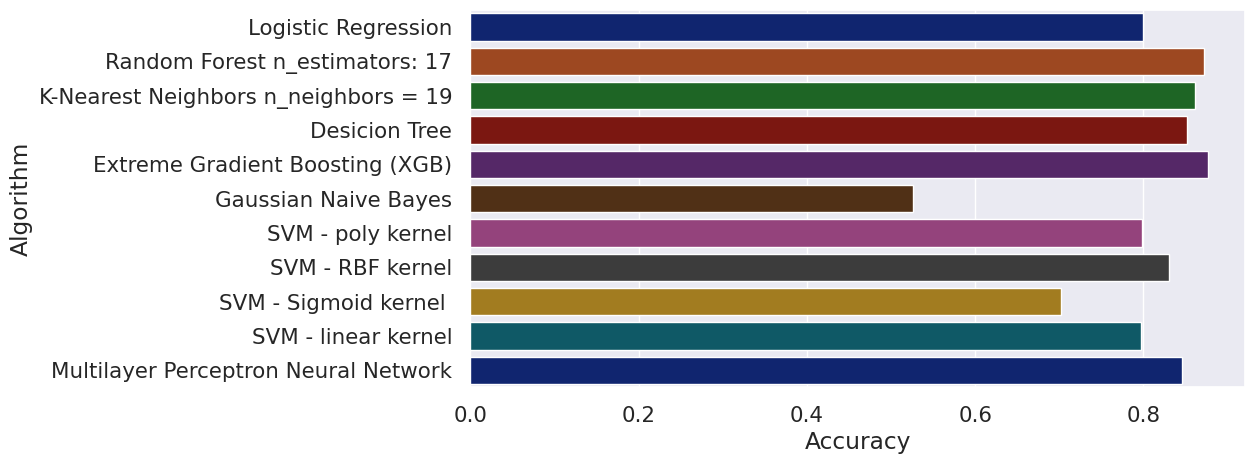

In [28]:
plt.figure(figsize=[10,5],dpi = 100)
#plt.title('Classifier vs Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Algorithm')
sb.barplot(x = acc, y = model, palette='dark')
#sb.barplot(x = df['Accuracy'],y = model,palette='dark',  hue_order = model)

In [29]:
df.iplot(kind='bar', xTitle = 'Classifier', yTitle='Accuracy',
                   title='Classifier vs Accuracy',color='red')

### Creamos nuevo DataFrame con la importancia según cada característica

In [30]:
df_impt = pd.DataFrame(cl_rf.feature_importances_, index = X_list,
                       columns = ['importance']).sort_values('importance', ascending=[False])
df_impt

,importance
lead_time,0.474737
avg_price_per_room,0.320288
no_of_special_requests,0.092195
market_segment_type,0.068149
room_type_reserved,0.015875
type_of_meal_plan,0.015762
required_car_parking_space,0.007416
repeated_guest,0.005578


In [31]:
df_impt.iplot(kind='bar', xTitle = 'Feature', yTitle='Importance',
                   title='Feature vs Importance',color='green')